### 1. Исследование данные Russian Handwritten Text.v7i.coco

In [4]:
from pathlib import Path
import json

roboflow_dir = Path("C:/Users/bleshchenko/YandexDisk/HandwrittenOCR/datasets/raw/Russian Handwritten Text.v7i.coco/test")
annot_file = roboflow_dir / "_annotations.coco.json"

print("="*60)
print("ROBOFLOW STRUCTURE ANALYSIS")
print("="*60)

with open(annot_file, encoding='utf-8') as f:
    data = json.load(f)

print(f"Keys: {list(data.keys())}")
print(f"Images: {len(data.get('images', []))}")
print(f"Annotations: {len(data.get('annotations', []))}")
print(f"Categories: {len(data.get('categories', []))}")

# Посмотреть первую аннотацию
if data.get('annotations'):
    first_ann = data['annotations'][0]
    print(f"\nПервая аннотация:")
    print(json.dumps(first_ann, indent=2, ensure_ascii=False)[:1000])

# Посмотреть первое изображение
if data.get('images'):
    first_img = data['images'][0]
    print(f"\nПервое изображение:")
    print(json.dumps(first_img, indent=2, ensure_ascii=False)[:500])


ROBOFLOW STRUCTURE ANALYSIS
Keys: ['info', 'licenses', 'categories', 'images', 'annotations']
Images: 9
Annotations: 627
Categories: 2

Первая аннотация:
{
  "id": 0,
  "image_id": 0,
  "category_id": 1,
  "bbox": [
    771,
    478,
    492.05,
    152.7
  ],
  "area": 75136.035,
  "segmentation": [],
  "iscrowd": 0
}

Первое изображение:
{
  "id": 0,
  "license": 1,
  "file_name": "50_16_JPG.rf.1a3c914b80b2f972246061757fffcc4c.jpg",
  "height": 1512,
  "width": 1512,
  "date_captured": "2023-02-08T17:54:01+00:00"
}


### 2.1. Исследование данных school_notebooks_ru 

In [5]:
school_dir = Path("C:/Users/bleshchenko/YandexDisk/HandwrittenOCR/datasets/raw/school_notebooks_ru")
train_ann = school_dir / "annotations_val.json"

print("="*60)
print("SCHOOL NOTEBOOKS STRUCTURE ANALYSIS")
print("="*60)

with open(train_ann, encoding='utf-8') as f:
    data = json.load(f)

print(f"Keys: {list(data.keys())}")
print(f"Images: {len(data.get('images', []))}")
print(f"Annotations: {len(data.get('annotations', []))}")

# Первая аннотация
if data.get('annotations'):
    first_ann = data['annotations'][0]
    print(f"\nПервая аннотация:")
    print(json.dumps(first_ann, indent=2, ensure_ascii=False)[:1000])

# Первое изображение
if data.get('images'):
    first_img = data['images'][0]
    print(f"\nПервое изображение:")
    print(json.dumps(first_img, indent=2, ensure_ascii=False)[:500])


SCHOOL NOTEBOOKS STRUCTURE ANALYSIS
Keys: ['categories', 'images', 'annotations']
Images: 150
Annotations: 34623

Первая аннотация:
{
  "category_id": 0,
  "image_id": 0,
  "group_id": 17,
  "segmentation": [
    [
      931.85,
      1810.61,
      933.09,
      1787.55,
      908.79,
      1787.55,
      891.09,
      1804.84,
      901.38,
      1867.43,
      947.5,
      1874.02,
      1028.2,
      1864.55,
      1098.19,
      1867.43,
      1150.89,
      1867.84,
      1167.36,
      1860.43,
      1162.83,
      1828.31,
      1087.9,
      1820.9,
      982.49,
      1815.96,
      962.32,
      1819.67,
      970.97,
      1785.49,
      947.08,
      1779.73
    ]
  ],
  "attributes": {
    "occluded": false,
    "translation": "Своими"
  }
}

Первое изображение:
{
  "height": 3000,
  "width": 4000,
  "id": 0,
  "file_name": "2638.jpg"
}


## 2.2. Преобразование полигона в bbox и загрузка аннотаций в единый формат

In [7]:
import json
import pandas as pd
from pathlib import Path
import cv2

school_dir = Path("C:/Users/bleshchenko/YandexDisk/HandwrittenOCR/datasets/raw/school_notebooks_ru")

def polygon_to_bbox(polygon):
    """Конвертировать полигон в bbox"""
    if not polygon or len(polygon) < 4:
        return None
    
    xs = polygon[0::2]
    ys = polygon[1::2]
    
    x_min, y_min = min(xs), min(ys)
    x_max, y_max = max(xs), max(ys)
    
    return {
        "left": int(x_min),
        "top": int(y_min),
        "width": int(x_max - x_min),
        "height": int(y_max - y_min)
    }

def load_school_notebooks():
    """Загрузить School Notebooks в единый формат"""
    records = []
    
    # Загрузить все аннотации (train, val, test)
    for split in ["train", "val", "test"]:
        ann_file = school_dir / f"annotations_{split}.json"
        
        if not ann_file.exists():
            continue
        
        print(f"Загрузка {split}...")
        
        with open(ann_file, encoding='utf-8') as f:
            data = json.load(f)
        
        # Создать маппинг image_id -> filename
        id_to_filename = {}
        for img in data.get("images", []):
            id_to_filename[img["id"]] = img["file_name"]
        
        # Обработать аннотации
        for ann in data.get("annotations", []):
            image_id = ann.get("image_id")
            filename = id_to_filename.get(image_id)
            
            if not filename:
                continue
            
            # Извлечь текст
            text = ""
            if "attributes" in ann:
                attrs = ann["attributes"]
                text = attrs.get("translation") or attrs.get("text", "")
            
            if not text or not text.strip():
                continue
            
            # Конвертировать полигон в bbox
            bbox = None
            if ann.get("segmentation") and ann["segmentation"]:
                bbox = polygon_to_bbox(ann["segmentation"][0])
            
            img_path = school_dir / "images" / "images" / filename
            
            if not img_path.exists():
                print("Не найдено изображение:", img_path)
                continue
            
            records.append({
                "image_path": str(img_path),
                "text": text.strip(),
                "source": "SchoolNotebooks",
                "split": split,
                "bbox": bbox
            })
    
    return records


# Загрузить
school_records = load_school_notebooks()
print(f"\n{'='*60}")
print(f"Загружено из School Notebooks: {len(school_records)} записей")

# Преобразуем в DataFrame
df_school = pd.DataFrame(school_records)

print(f"\nПримеры:")
print(df_school.head(10))

print(f"\nРаспределение по splits:")
print(df_school["split"].value_counts())

print(f"\nДлина текста:")
df_school["text_len"] = df_school["text"].str.len()
print(df_school["text_len"].describe())

# ================================================================
# ✔ Сохранение результата
# ================================================================

output_dir = Path("C:/Users/bleshchenko/YandexDisk/HandwrittenOCR/datasets/raw/school_notebooks_ru/processed")
output_dir.mkdir(parents=True, exist_ok=True)

# Сохранить JSON
json_path = output_dir / "school_records.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(school_records, f, ensure_ascii=False, indent=2)

# Сохранить CSV
csv_path = output_dir / "school_records.csv"
df_school.to_csv(csv_path, index=False, encoding="utf-8")

# Сохранить TSV
tsv_path = output_dir / "school_records.tsv"
df_school.to_csv(tsv_path, index=False, sep="\t", encoding="utf-8")

print(f"\nГотово! Файлы сохранены:")
print(f"JSON → {json_path}")
print(f"CSV  → {csv_path}")
print(f"TSV  → {tsv_path}")


Загрузка train...
Загрузка val...
Загрузка test...

Загружено из School Notebooks: 324312 записей

Примеры:
                                          image_path      text  \
0  C:\Users\bleshchenko\YandexDisk\HandwrittenOCR...    прил.,   
1  C:\Users\bleshchenko\YandexDisk\HandwrittenOCR...       п.,   
2  C:\Users\bleshchenko\YandexDisk\HandwrittenOCR...        П.   
3  C:\Users\bleshchenko\YandexDisk\HandwrittenOCR...         в   
4  C:\Users\bleshchenko\YandexDisk\HandwrittenOCR...       ч.,   
5  C:\Users\bleshchenko\YandexDisk\HandwrittenOCR...        ж.   
6  C:\Users\bleshchenko\YandexDisk\HandwrittenOCR...       ед.   
7  C:\Users\bleshchenko\YandexDisk\HandwrittenOCR...         в   
8  C:\Users\bleshchenko\YandexDisk\HandwrittenOCR...       р.,   
9  C:\Users\bleshchenko\YandexDisk\HandwrittenOCR...  сообщали   

            source  split                                               bbox  
0  SchoolNotebooks  train  {'left': 1301, 'top': 1430, 'width': 163, 'hei...  
1  Scho

### 3. Исследование school_notebooks_ru

In [ ]:
import json
import pandas as pd
from pathlib import Path
import cv2

school_dir = Path("C:/Users/bleshchenko/YandexDisk/HandwrittenOCR/datasets/raw/school_notebooks_ru")

def polygon_to_bbox(polygon):
    """Конвертировать полигон в bbox"""
    if not polygon or len(polygon) < 4:
        return None
    
    xs = polygon[0::2]
    ys = polygon[1::2]
    
    x_min, y_min = min(xs), min(ys)
    x_max, y_max = max(xs), max(ys)
    
    return {
        "left": int(x_min),
        "top": int(y_min),
        "width": int(x_max - x_min),
        "height": int(y_max - y_min)
    }

def resolve_image_path(base_dir, filename):
    """Автодетектор пути до файла изображения"""
    p1 = base_dir / "images" / filename
    p2 = base_dir / "images" / "images" / filename
    if p1.exists():
        return p1
    if p2.exists():
        return p2
    return None

def load_school_notebooks():
    """Загрузить School Notebooks в единый формат"""
    records = []

    for split in ["train", "val", "test"]:
        ann_file = school_dir / f"annotations_{split}.json"
        if not ann_file.exists():
            continue
        
        print(f"Загрузка {split}...")
        
        with open(ann_file, encoding='utf-8') as f:
            data = json.load(f)
        
        # image_id -> file_name
        id_to_filename = {img["id"]: img["file_name"] for img in data.get("images", [])}
        
        for ann in data.get("annotations", []):
            image_id = ann.get("image_id")
            filename = id_to_filename.get(image_id)
            if not filename:
                continue
            
            # текст
            text = ""
            if "attributes" in ann:
                attrs = ann["attributes"]
                text = attrs.get("translation") or attrs.get("text", "")
            
            if not text or not text.strip():
                continue
            
            # bbox
            seg = ann.get("segmentation")
            bbox = None
            if seg:
                if isinstance(seg[0], list):  # [[...]]
                    poly = seg[0]
                else:  # [...]
                    poly = seg
                bbox = polygon_to_bbox(poly)
            
            # проверяем существование файла
            img_path = resolve_image_path(school_dir, filename)
            if not img_path:
                continue
            
            # сохраняем НОВУЮ структуру записи
            records.append({
                "image": filename,   # только имя файла
                "text": text.strip(),
                "bbox": bbox
            })
    
    return records

# Загружаем
school_records = load_school_notebooks()
print(f"\n{'='*60}")
print(f"Загружено записей: {len(school_records)}")

# DataFrame
df_school = pd.DataFrame(school_records)

# ================================================================
# Сохранение результата (JSON, CSV, TSV)
# ================================================================

output_dir = Path("C:/Users/bleshchenko/YandexDisk/HandwrittenOCR/datasets/processed/school_notebooks_ru")
output_dir.mkdir(parents=True, exist_ok=True)

# JSON
json_path = output_dir / "school_records.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(school_records, f, ensure_ascii=False, indent=2)

# CSV
csv_path = output_dir / "school_records.csv"
df_school.to_csv(csv_path, index=False, encoding="utf-8")

# TSV
tsv_path = output_dir / "school_records.tsv"
df_school.to_csv(tsv_path, index=False, sep="\t", encoding="utf-8")

print("\nФайлы сохранены:")
print("JSON →", json_path)
print("CSV  →", csv_path)
print("TSV  →", tsv_path)

Загрузка train...
Загрузка val...
Загрузка test...

Загружено записей: 324312

Файлы сохранены:
JSON → C:\Users\bleshchenko\YandexDisk\HandwrittenOCR\datasets\processed\school_records.json
CSV  → C:\Users\bleshchenko\YandexDisk\HandwrittenOCR\datasets\processed\school_records.csv
TSV  → C:\Users\bleshchenko\YandexDisk\HandwrittenOCR\datasets\processed\school_records.tsv


### 4. Код визуализации bbox поверх изображения

In [14]:
def show_bbox(record):
    # Восстанавливаем путь к изображению
    img_path = resolve_image_path(school_dir, record["image"])
    if img_path is None:
        print("Не удалось найти изображение:", record["image"])
        return
    
    img = cv2.imread(str(img_path))
    if img is None:
        print("Не удалось загрузить изображение:", img_path)
        return
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    bbox = record["bbox"]
    if bbox:
        x, y, w, h = bbox["left"], bbox["top"], bbox["width"], bbox["height"]
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(record["text"])
    plt.axis("off")
    plt.show()


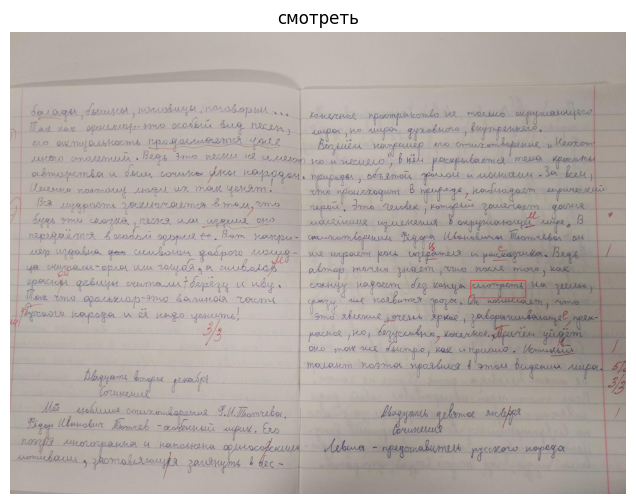

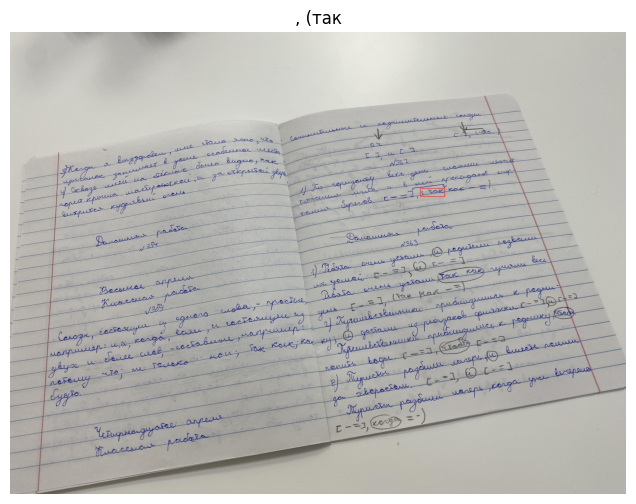

In [15]:
import random
for rec in random.sample(school_records, 2):
    show_bbox(rec)

### 5.Вывод всех bbox на одном изображении

Images dir: c:\Users\bleshchenko\YandexDisk\HandwrittenOCR\datasets\raw\school_notebooks_ru\images\images
Records path: c:\Users\bleshchenko\YandexDisk\HandwrittenOCR\datasets\processed\school_notebooks_ru\school_records.json


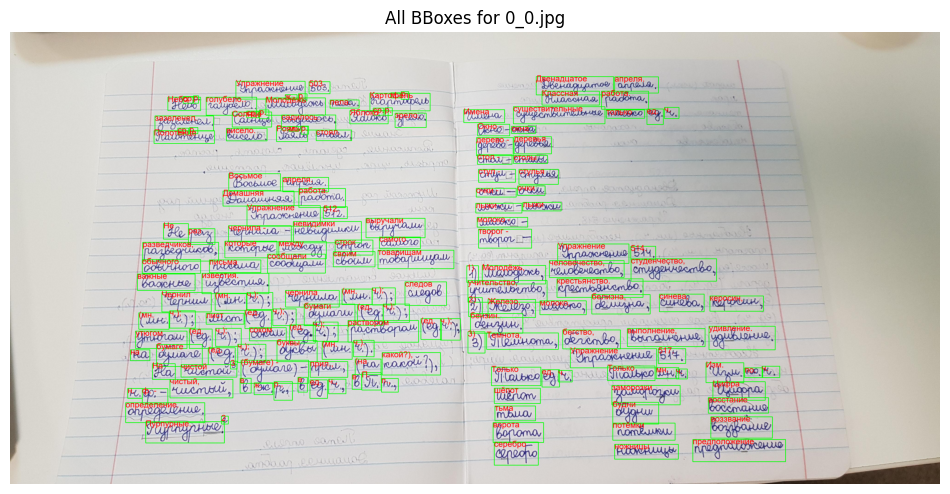

In [5]:
import cv2
import matplotlib.pyplot as plt
import json
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import numpy as np


# -------------------------------------------------------------
# Функция безопасной загрузки шрифта (работает везде)
# -------------------------------------------------------------
def load_unicode_font(font_size=22):
    # Популярные пути к шрифтам на разных ОС
    candidate_paths = [
        # Windows
        "C:/Windows/Fonts/arial.ttf",
        "C:/Windows/Fonts/seguisym.ttf",
        "C:/Windows/Fonts/tahoma.ttf",

        # Linux / Ubuntu / Colab
        "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",
        "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf",

        # macOS
        "/System/Library/Fonts/Supplemental/Arial.ttf",
        "/System/Library/Fonts/Supplemental/Helvetica.ttf",
    ]

    for path in candidate_paths:
        try:
            return ImageFont.truetype(path, font_size)
        except:
            continue

    # Если ничего не нашли — fallback (работает с кириллицей!)
    print("⚠️ Не удалось найти TTF-шрифт. Используется встроенный моноширинный шрифт PIL.")
    return ImageFont.load_default()


# -------------------------------------------------------------
# Пути к данным
# -------------------------------------------------------------
notebooks_dir = Path.cwd()
datasets_dir = notebooks_dir.parent / "datasets"

images_dir = datasets_dir / "raw" / "school_notebooks_ru" / "images" / "images"
records_path = datasets_dir / "processed" / "school_notebooks_ru" / "school_records.json"

print("Images dir:", images_dir)
print("Records path:", records_path)


# -------------------------------------------------------------
# Загружаем аннотации
# -------------------------------------------------------------
with open(records_path, "r", encoding="utf-8") as f:
    school_records = json.load(f)


# -------------------------------------------------------------
# Основная функция визуализации
# -------------------------------------------------------------
def show_bboxes_for_image(image_name, records):
    # выбираем все bbox для изображения
    image_records = [r for r in records if r["image"] == image_name]

    if not image_records:
        print("Нет аннотаций для изображения:", image_name)
        return

    # загружаем изображение
    img_path = images_dir / image_name
    img = cv2.imread(str(img_path))

    if img is None:
        print("Не удалось загрузить изображение:", img_path)
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # ---------------------------------------------------------
    # БЛОК 1 — Отрисовка bbox через OpenCV
    # ---------------------------------------------------------
    for rec in image_records:
        bbox = rec["bbox"]
        if bbox:
            x, y, w, h = bbox["left"], bbox["top"], bbox["width"], bbox["height"]
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # ---------------------------------------------------------
    # БЛОК 2 — Нанесение текста через PIL (Unicode как надо)
    # ---------------------------------------------------------
    ADD_TEXT = True          # ← включить/выключить подписи
    FONT_SIZE = 36
    TEXT_COLOR = (255, 0, 0)  # красный; синий: (0, 0, 255)

    if ADD_TEXT:
        pil_img = Image.fromarray(img)
        draw = ImageDraw.Draw(pil_img)

        font = load_unicode_font(FONT_SIZE)

        for rec in image_records:
            bbox = rec["bbox"]
            if bbox:
                x, y = bbox["left"], bbox["top"]
                text = rec["text"]

                # Чуть выше bbox
                draw.text((x, y - 12), text, font=font, fill=TEXT_COLOR)

        img = np.array(pil_img)

    # ---------------------------------------------------------
    # Показ результата
    # ---------------------------------------------------------
    plt.figure(figsize=(12, 10))
    plt.imshow(img)
    plt.title(f"All BBoxes for {image_name}")
    plt.axis("off")
    plt.show()


# -------------------------------------------------------------
# Пример вызова
# -------------------------------------------------------------
show_bboxes_for_image("0_0.jpg", school_records)
